In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
#download data
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform = transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform = transforms.ToTensor())
print(trainset) # print trainset info

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [3]:
# set up the data loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=False, num_workers=2)
print('Number of batches per epoch:', len(trainloader))

Number of batches per epoch: 6250


In [4]:
# use gpu if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Using', device)
#check
temp = torch.zeros(10)
temp.to(device)

Using cpu


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
class_labels = ('plane', 'cars', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# let's load a batch
images, labels = next(iter(trainloader))
print(images.shape, labels.shape)

torch.Size([8, 3, 32, 32]) torch.Size([8])


torchvision grid shape: torch.Size([3, 36, 274])
transposed numpy grid shape: torch.Size([36, 274, 3])


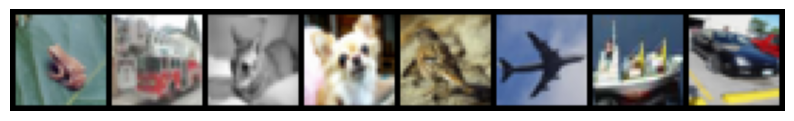

In [7]:
# lets use the makegrid function to view the batch in matplotlib
img = torchvision.utils.make_grid(images)
print('torchvision grid shape:', img.shape)
# matplotlib requires the images to have the number of channels as the last dimension
img_transposed = np.transpose(img, (1,2,0))
print('transposed numpy grid shape:', img_transposed.shape)
plt.figure(figsize=(10,5))
plt.imshow(img_transposed)
plt.axis('off')
plt.show()

In [8]:

# now we build our model
in_channels = 3
h1_channels, h2_channels = 6, 16 # hidden channels
k_conv_size = 5 # 5x5
out_dim = len(class_labels)

# let's understand how the dimensionality changes:
print('Initial Shape:'.ljust(25), images.shape)
out = nn.Conv2d(in_channels, h1_channels, k_conv_size)(images)
print('First Conv: (3, 6, 5):'.ljust(25), out.shape)
out = nn.MaxPool2d(kernel_size=2)(out)
print('Pool (2x2):'.ljust(25), out.shape)
out = nn.Conv2d(h1_channels, h2_channels, k_conv_size)(out)
print('Second Conv (6, 16, 5):'.ljust(25), out.shape)
out = nn.MaxPool2d(kernel_size=2)(out)
print('Pool (2x2):'.ljust(25), out.shape)

Initial Shape:            torch.Size([8, 3, 32, 32])
First Conv: (3, 6, 5):    torch.Size([8, 6, 28, 28])
Pool (2x2):               torch.Size([8, 6, 14, 14])
Second Conv (6, 16, 5):   torch.Size([8, 16, 10, 10])
Pool (2x2):               torch.Size([8, 16, 5, 5])


In [9]:
# now we build our model
in_channels = 3
h1_channels, h2_channels = 6, 16 # hidden channels
k_conv_size = 5 # 5x5

class CNN(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels, h1_channels, k_conv_size),
        nn.BatchNorm2d(h1_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

      self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(h1_channels, h2_channels, k_conv_size),
        nn.BatchNorm2d(h2_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

      self.fc_layer = nn.Sequential(
          nn.Linear(16 * 5 * 5, 120),
          nn.ReLU(),
          nn.Linear(120, 84),
          nn.ReLU(),
          nn.Linear(84, out_dim))

    def forward(self, x):
      x = self.conv_layer_1(x)
      x = self.conv_layer_2(x)
      x = torch.flatten(x, 1)
      x = self.fc_layer(x)
      return x

model = CNN().to(device)
# check it works
model(images.to(device)).shape

torch.Size([8, 10])

In [10]:
learning_rate = 0.003
num_epochs = 5
criterion = nn.CrossEntropyLoss() # performs softmax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
model.train()
for epoch in range(num_epochs):
  loss_history = 0
  for i, (images, labels) in enumerate(trainloader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

    optimizer.zero_grad() # wipe gradients
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    loss_history += loss.item()

    if((i+1) % 1250 == 0):
      print(f'epoch({epoch}), step({i+1}) train_loss: {loss_history/1250:.2f}')
      loss_history = 0

epoch(0), step(1250) train_loss: 1.86
epoch(0), step(2500) train_loss: 1.64
epoch(0), step(3750) train_loss: 1.55
epoch(0), step(5000) train_loss: 1.49
epoch(0), step(6250) train_loss: 1.47
epoch(1), step(1250) train_loss: 1.41
epoch(1), step(2500) train_loss: 1.38
epoch(1), step(3750) train_loss: 1.35
epoch(1), step(5000) train_loss: 1.33
epoch(1), step(6250) train_loss: 1.33
epoch(2), step(1250) train_loss: 1.27
epoch(2), step(2500) train_loss: 1.25
epoch(2), step(3750) train_loss: 1.27
epoch(2), step(5000) train_loss: 1.24
epoch(2), step(6250) train_loss: 1.25
epoch(3), step(1250) train_loss: 1.20
epoch(3), step(2500) train_loss: 1.22
epoch(3), step(3750) train_loss: 1.20
epoch(3), step(5000) train_loss: 1.18
epoch(3), step(6250) train_loss: 1.20
epoch(4), step(1250) train_loss: 1.15
epoch(4), step(2500) train_loss: 1.17
epoch(4), step(3750) train_loss: 1.15
epoch(4), step(5000) train_loss: 1.16
epoch(4), step(6250) train_loss: 1.16


In [12]:
#test
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in testloader:
        images, label = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs,1) # returns val, index
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

    test_acc = (n_correct/n_samples) * 100

print(f'test acc: {test_acc:.2f}')

test acc: 62.73
